In [1]:
import os
os.chdir('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score 

import alpaca.utils.datasets.config as alpaca_config
alpaca_config.DATA_DIR = './datasets/alpaca_datasets'
from alpaca.ue import MCDUE
from alpaca.utils.datasets.builder import build_dataset
from alpaca.utils.ue_metrics import ndcg, uq_ll
from sklearn.model_selection import KFold



from scipy.special import logsumexp



from tqdm import tqdm

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_dim, 256)
        self.encoder_fc2 = nn.Linear(256, 128)
        self.encoder_fc3_mean = nn.Linear(128, latent_dim)
        self.encoder_fc3_logvar = nn.Linear(128, latent_dim)
        
        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 256)
        self.decoder_fc3 = nn.Linear(256, input_dim)
        
    def encode(self, x):
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        mean = self.encoder_fc3_mean(x)
        logvar = self.encoder_fc3_logvar(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z
    
    def decode(self, z):
        z = F.relu(self.decoder_fc1(z))
        z = F.relu(self.decoder_fc2(z))
        x_hat = torch.sigmoid(self.decoder_fc3(z))
        return x_hat
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [3]:
dataset = build_dataset('kin8nm', val_split=1)
x_train_tmp, y_train_tmp = dataset.dataset('train')
x_val_tmp, y_val_tmp = dataset.dataset('val')
x_total = np.concatenate([x_train_tmp, x_val_tmp])
y_total = np.concatenate([y_train_tmp, y_val_tmp])

In [4]:
n_splits = 20 
n_output_features = y_total.shape[1]
n_input_features = x_total.shape[1]

dropout_rate = 0.05
n_epochs = 300
lengthscale = 1e-2
latent_dim = 5

adam_lr = 1e-4
weight_decay = 1e-4

n_y_steps = 100

#DEBUGGING SECTION
execute_only_one_fold = True
target_reconstruction_multiplier = 1.0
kl_loss_weight = 4.0


Fold: 0
Epoch 0, Train Loss: 11.9976, Val Loss: 18.1770
Epoch 10, Train Loss: 1.4454, Val Loss: 3.0824
Epoch 20, Train Loss: 1.1698, Val Loss: 2.1702
Epoch 30, Train Loss: 1.0703, Val Loss: 1.8007
Epoch 40, Train Loss: 1.0164, Val Loss: 1.5826
Epoch 50, Train Loss: 0.9821, Val Loss: 1.4353
Epoch 60, Train Loss: 0.9577, Val Loss: 1.3328
Epoch 70, Train Loss: 0.9398, Val Loss: 1.2541
Epoch 80, Train Loss: 0.9257, Val Loss: 1.1950
Epoch 90, Train Loss: 0.9144, Val Loss: 1.1465
Epoch 100, Train Loss: 0.9051, Val Loss: 1.1063
Epoch 110, Train Loss: 0.8973, Val Loss: 1.0729
Epoch 120, Train Loss: 0.8906, Val Loss: 1.0446
Epoch 130, Train Loss: 0.8850, Val Loss: 1.0191
Epoch 140, Train Loss: 0.8802, Val Loss: 0.9974
Epoch 150, Train Loss: 0.8760, Val Loss: 0.9774
Epoch 160, Train Loss: 0.8721, Val Loss: 0.9599
Epoch 170, Train Loss: 0.8688, Val Loss: 0.9446
Epoch 180, Train Loss: 0.8659, Val Loss: 0.9306
Epoch 190, Train Loss: 0.8634, Val Loss: 0.9183
Epoch 200, Train Loss: 0.8610, Val Loss:

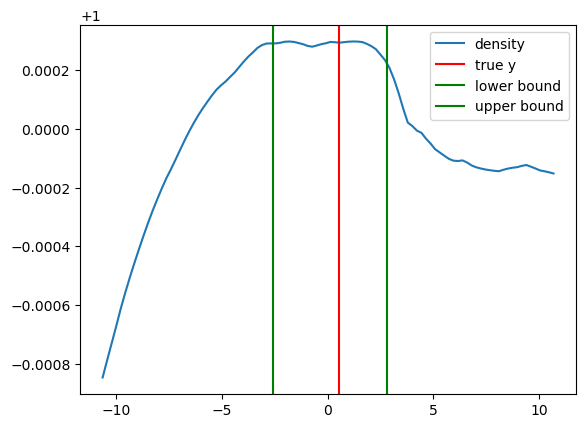

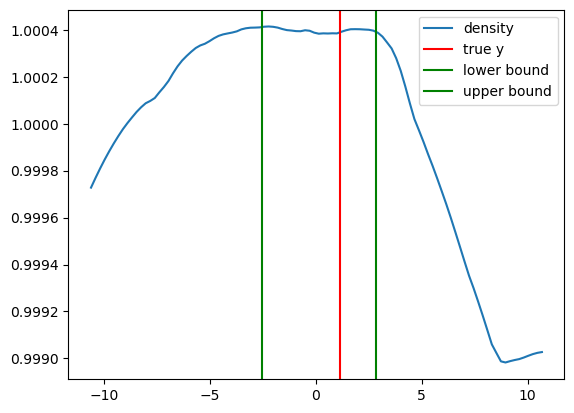

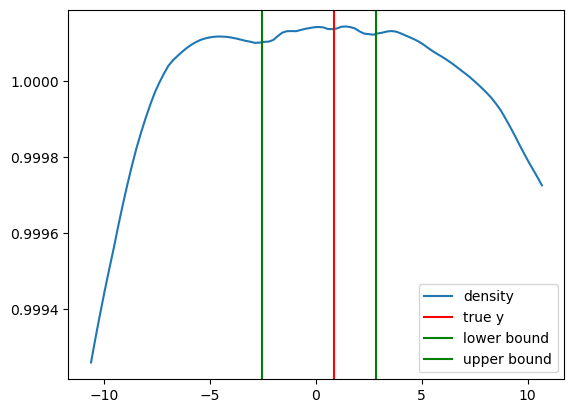

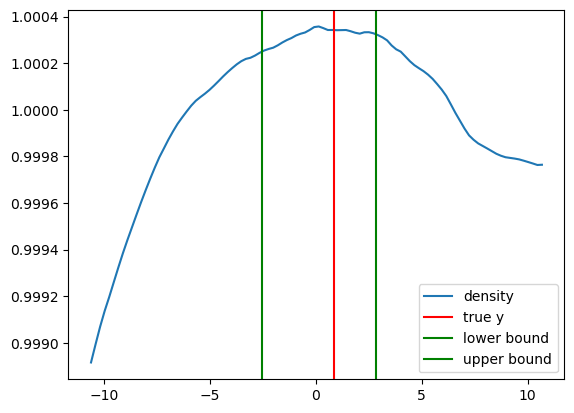

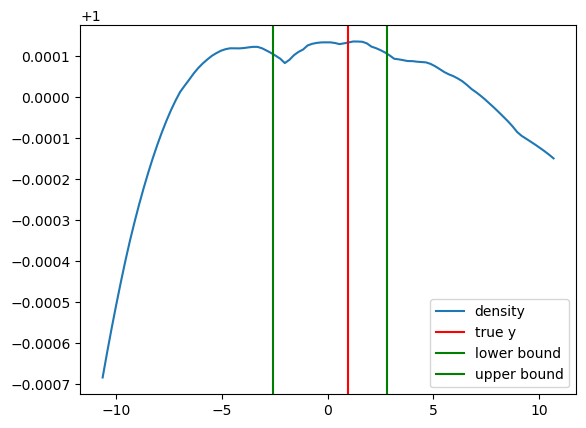

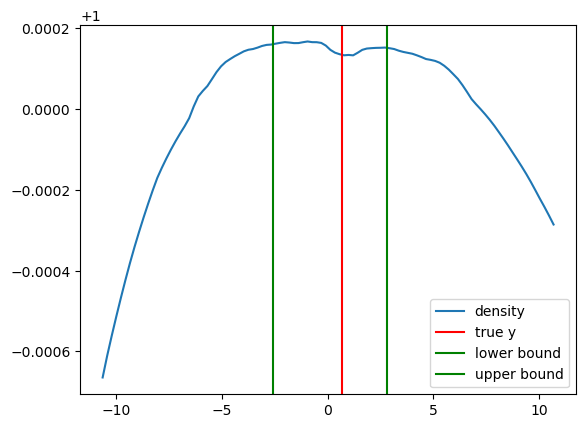

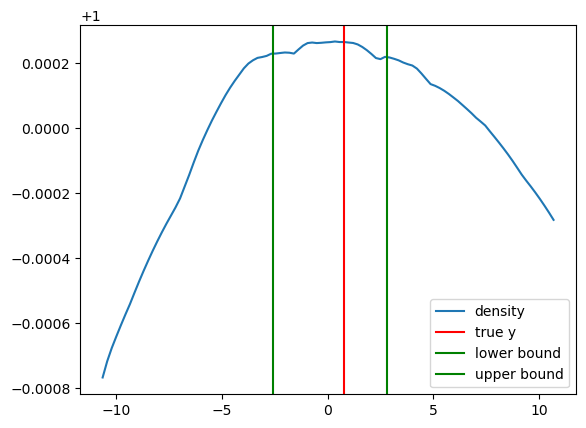

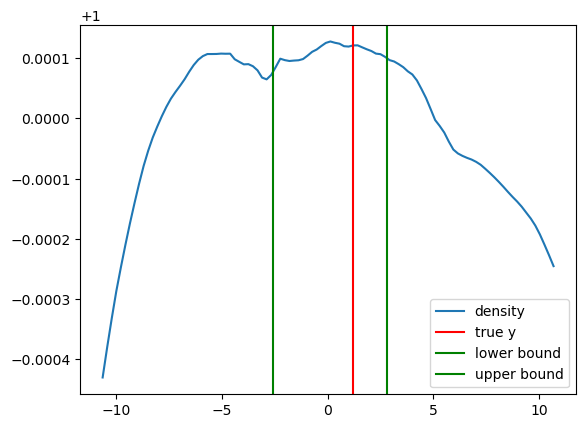

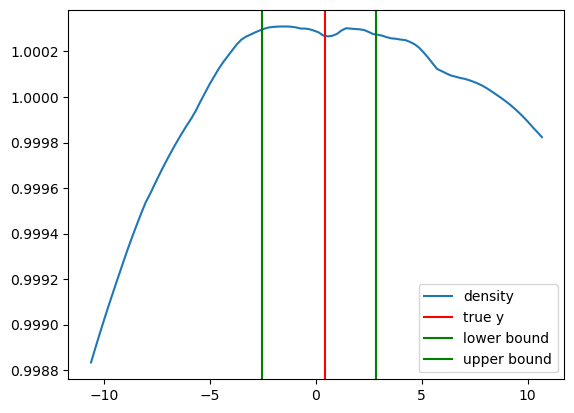

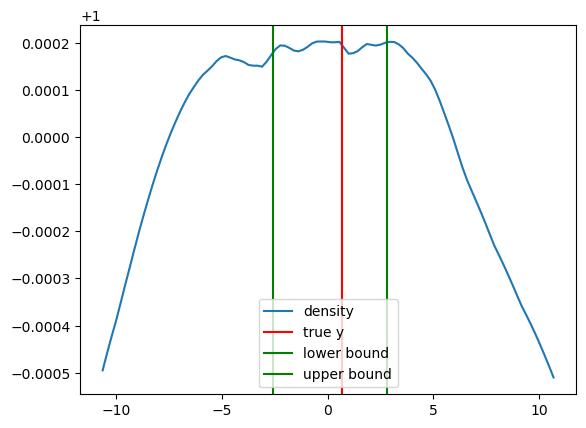

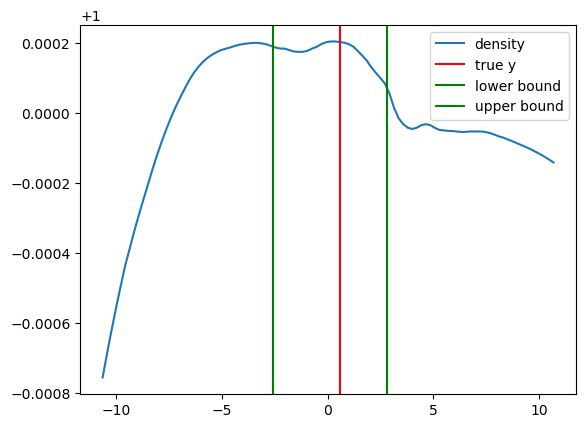

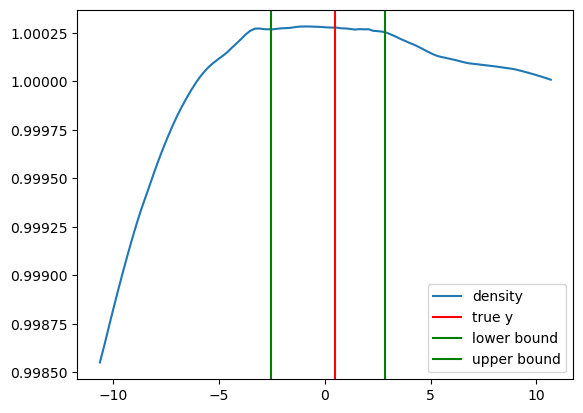

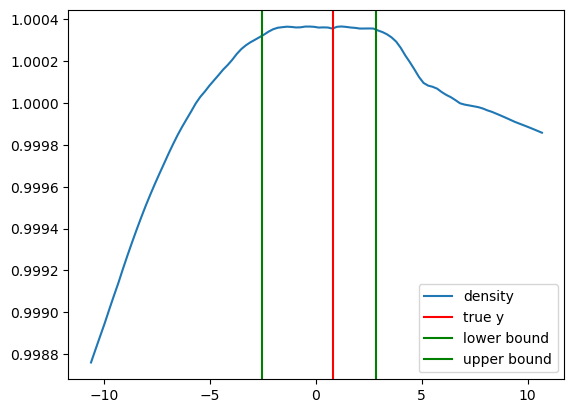

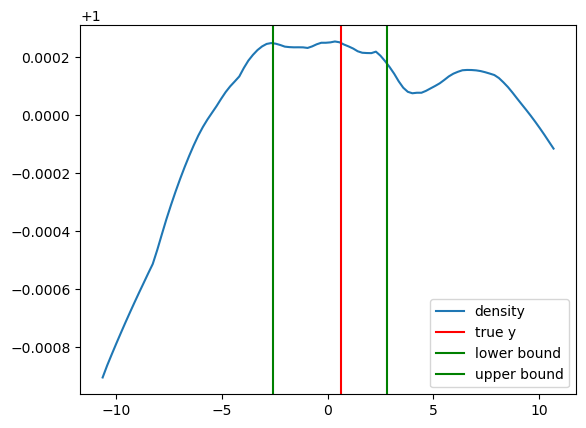

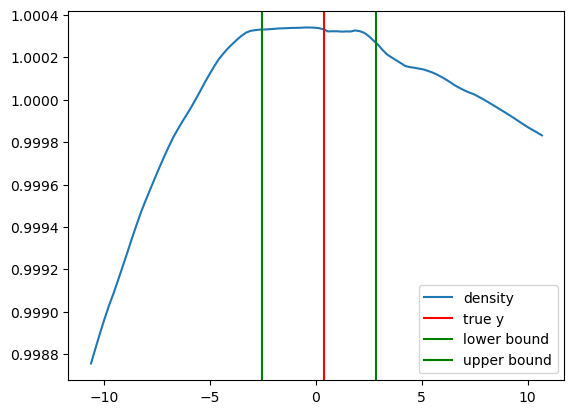

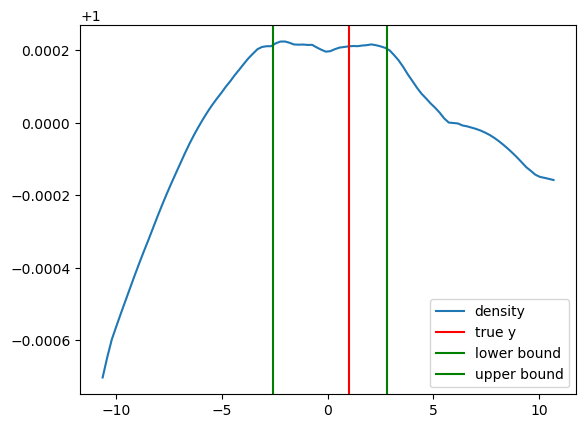

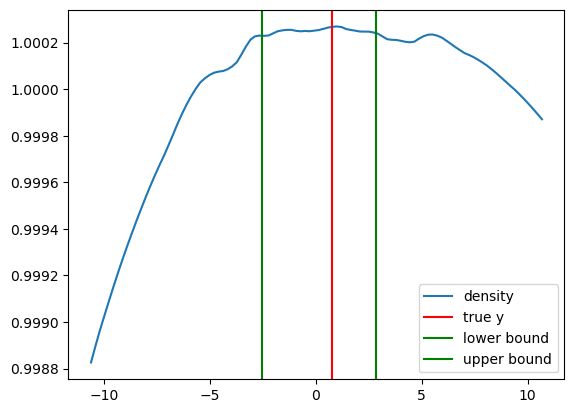

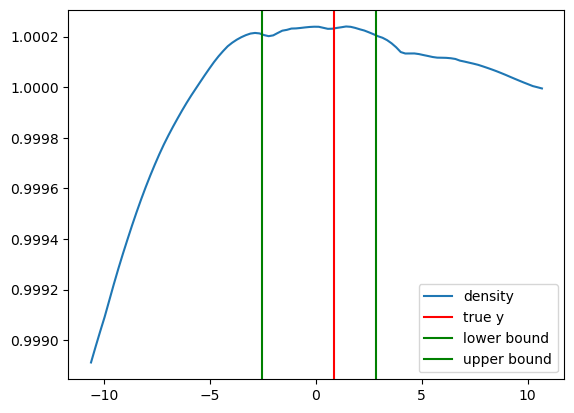

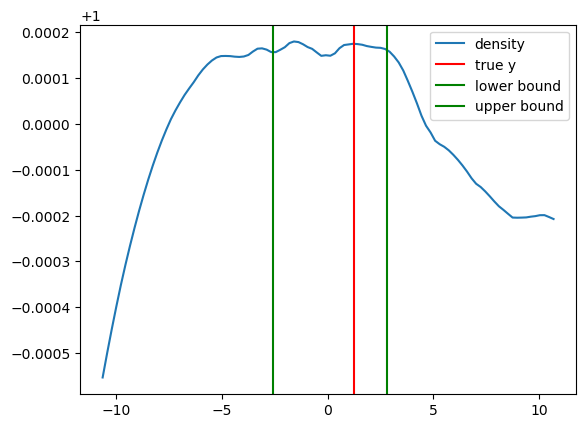

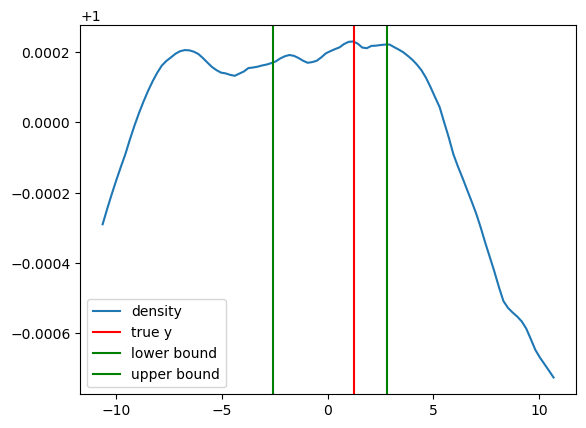

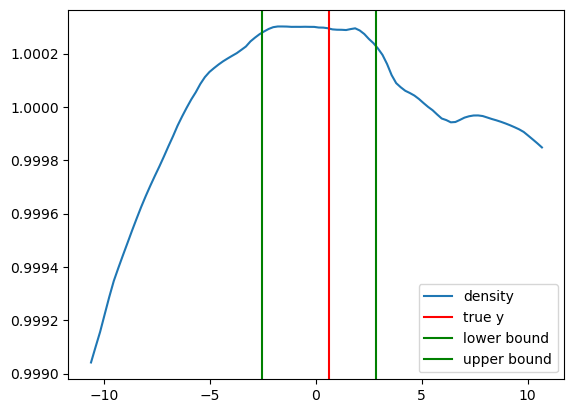

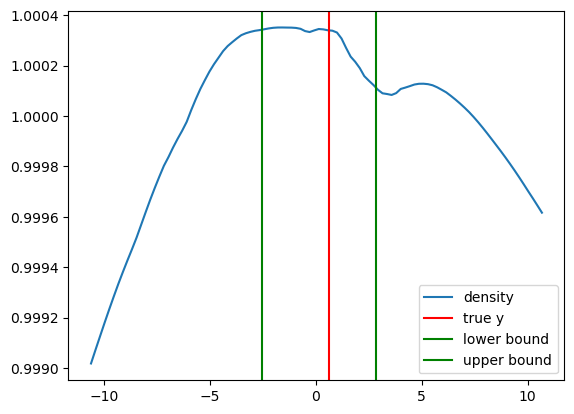

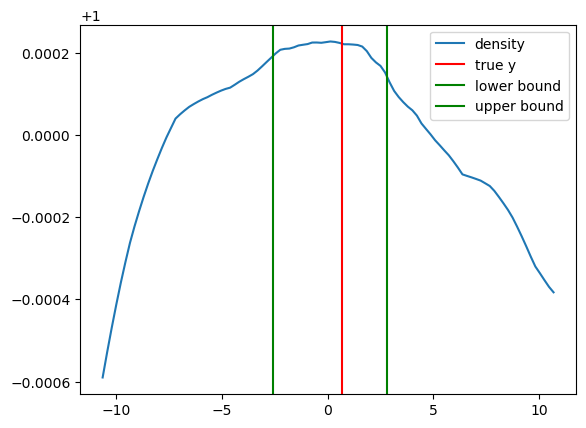

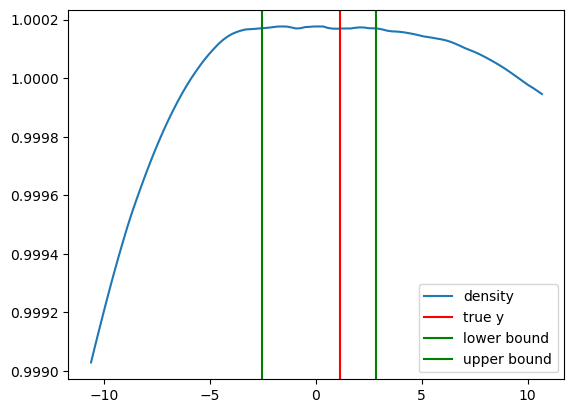

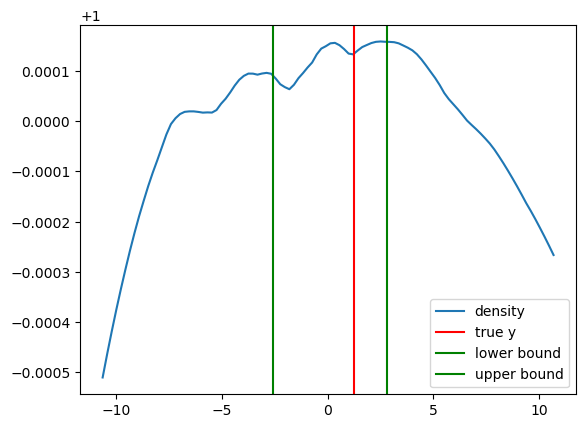

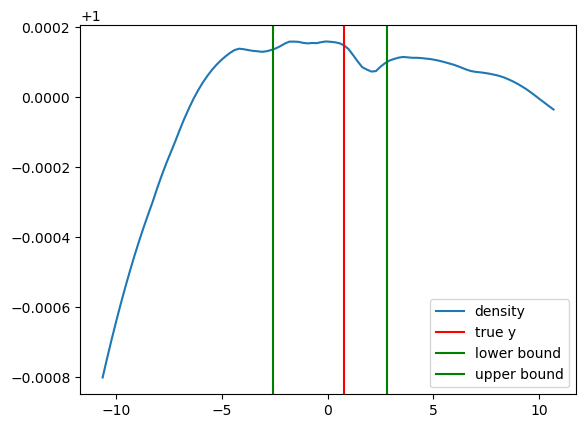

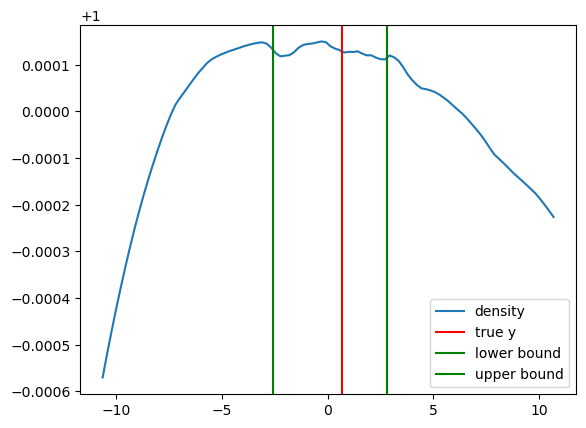

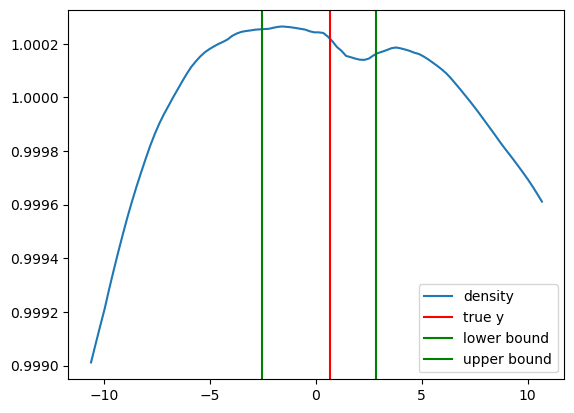

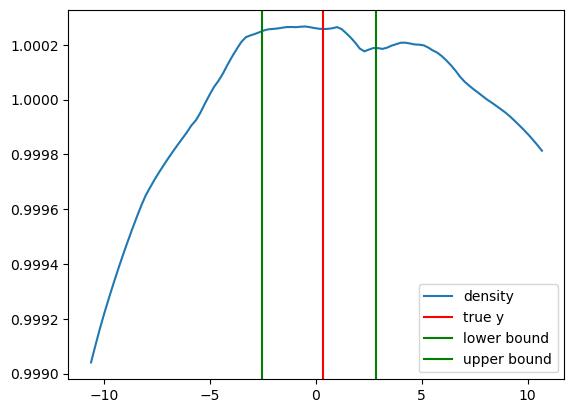

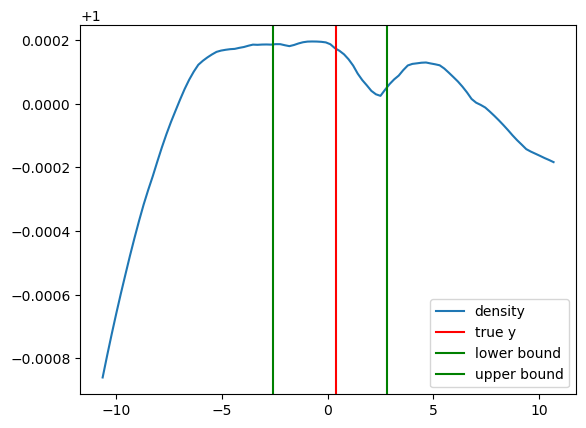

In [10]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for fold, (train_index, val_index) in enumerate(kf.split(x_total)):
    print("\nFold:", fold)
    x_train, y_train = x_total[train_index], y_total[train_index]
    x_val, y_val = x_total[val_index], y_total[val_index]

    mean_y = y_train.mean()
    std_y = y_train.std()

    y_train = (y_train - mean_y) / std_y

    train_ds = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    val_ds = TensorDataset(torch.FloatTensor(x_val), torch.FloatTensor(y_val))
    train_loader = DataLoader(train_ds, batch_size=512)
    val_loader = DataLoader(val_ds, batch_size=512)

    model = VAE(x_train.shape[1] + y_train.shape[1], latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4, weight_decay=1e-7)

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            net_input = torch.cat([x, y], dim=1)
            x_hat, mean, logvar = model(net_input)
            reconstruction_loss = F.mse_loss(x_hat, net_input, reduction = "none")
            reconstruction_loss[-1] *= target_reconstruction_multiplier
            reconstruction_loss = reconstruction_loss.mean()
            kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                net_input = torch.cat([x, y], dim=1)
                x_hat, mean, logvar = model(net_input)
                reconstruction_loss = F.mse_loss(x_hat, net_input)
                kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                loss = reconstruction_loss + kl_loss_weight * kl_loss
                val_loss += loss.item()
            val_loss /= len(val_loader)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    
    

    samples_for_plot = val_index[:30]
    x_plot, y_plot = x_total[samples_for_plot], y_total[samples_for_plot]

    max_min_difference = y_train.max() - y_train.min()
    lower_bound = y_train.min() - max_min_difference * 1.5
    upper_bound = y_train.max() + max_min_difference * 1.5

    step_size = (upper_bound - lower_bound) / n_y_steps
    steps = torch.tensor(np.arange(lower_bound, upper_bound, step_size)).view(-1, 1).float()

    with torch.no_grad():
        for x, y in zip(x_plot, y_plot):
            x = torch.tensor(x).float()
            x = x.repeat(steps.shape[0], 1)
            
            net_input = torch.cat([x, steps], dim=1)
            x_hat, mean, logvar = model(net_input)

            normalizing_constant = (2 * torch.pi) ** (-mean.shape[1] / 2)
            exponent = -0.5 * torch.sum(mean * mean, dim=1)
            densities = normalizing_constant * torch.exp(exponent)

            prior_x = densities.mean()
            densities = densities / prior_x

            plt.plot(steps, densities, label='density')
            plt.axvline(y, label='true y', color = 'red')
            plt.axvline(y_train.min(), label='lower bound', color='green')
            plt.axvline(y_train.max(), label='upper bound', color="green")
            plt.legend()
            plt.yscale("linear")
            #plt.ylim(0, 1.5)
            plt.show()

        
        
    torch.tensor(x_plot).float()

    if execute_only_one_fold:
        break



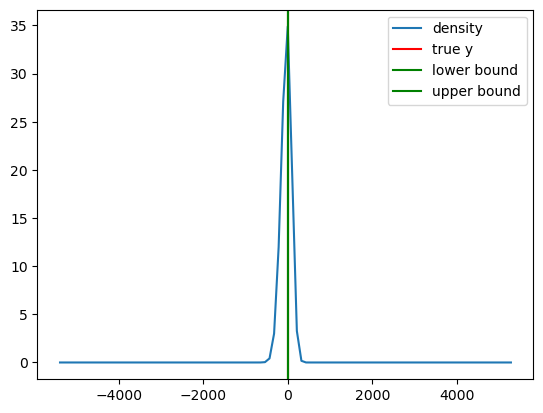

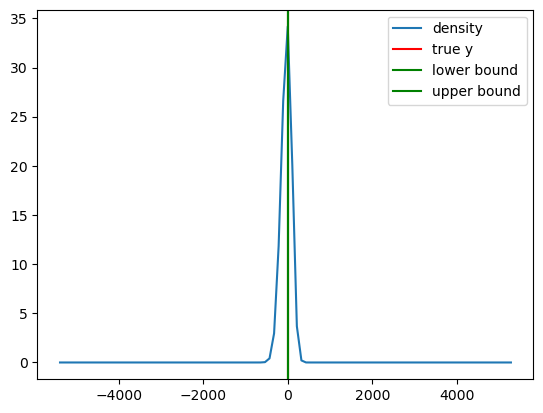

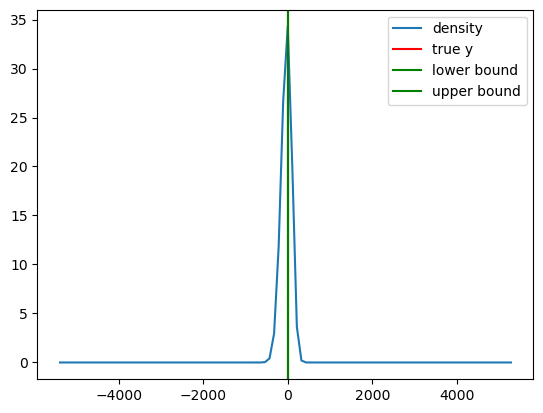

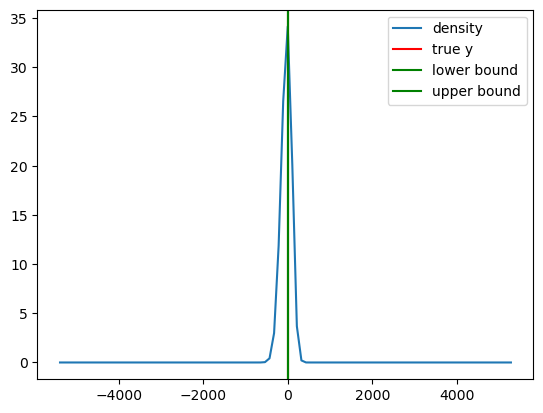

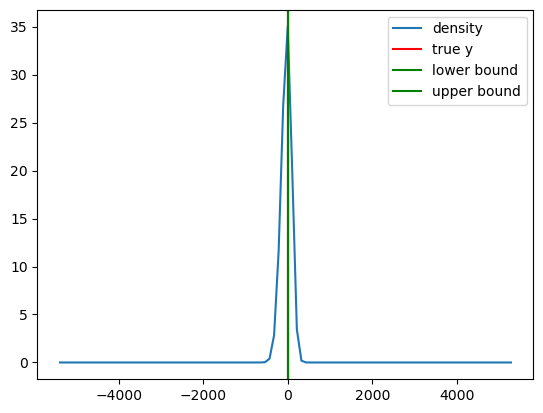

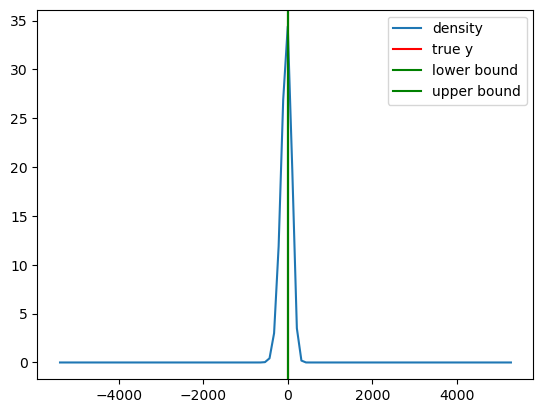

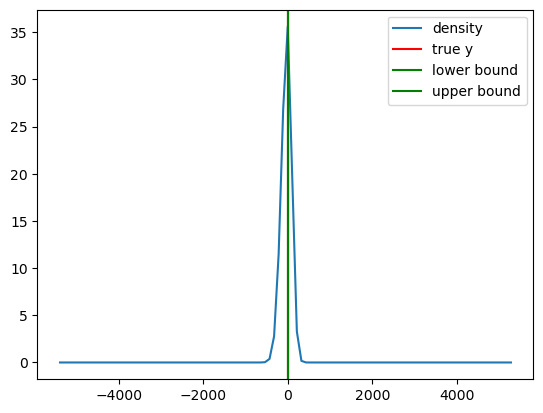

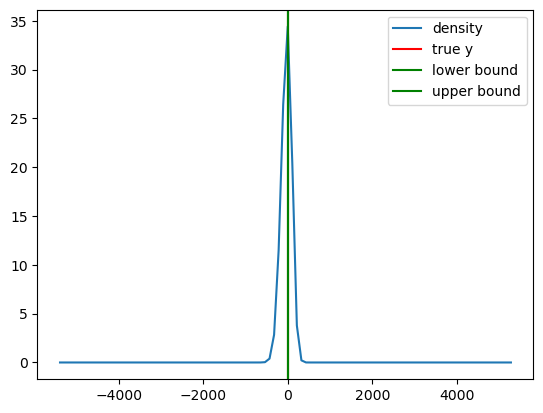

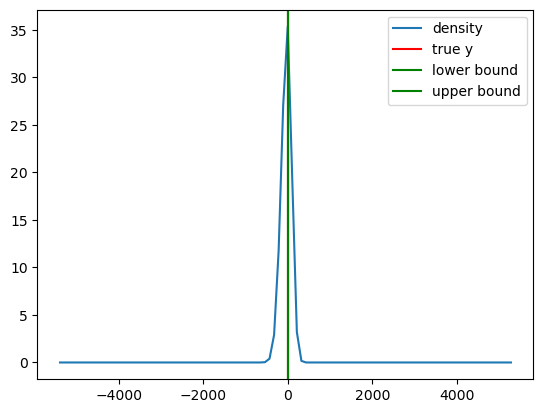

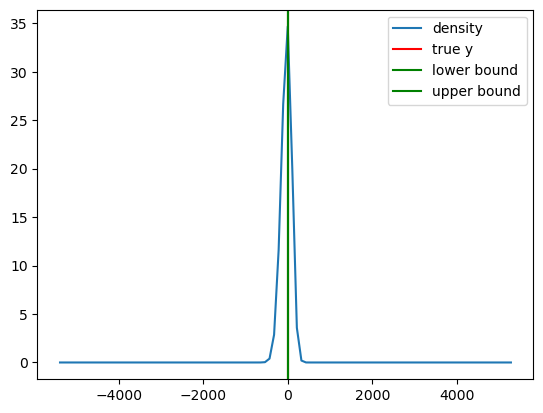

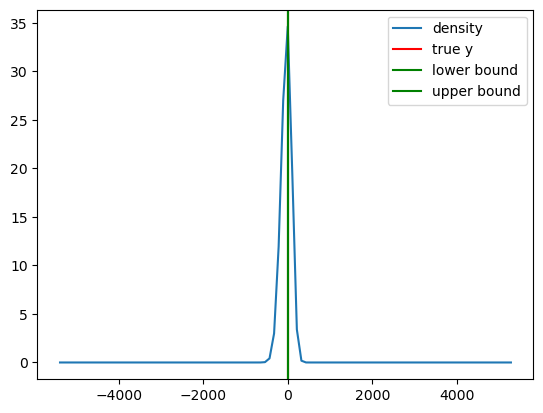

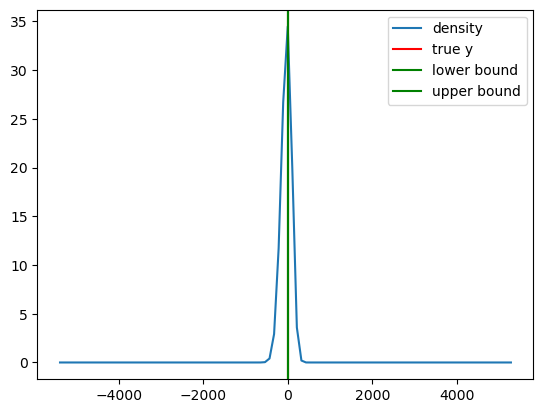

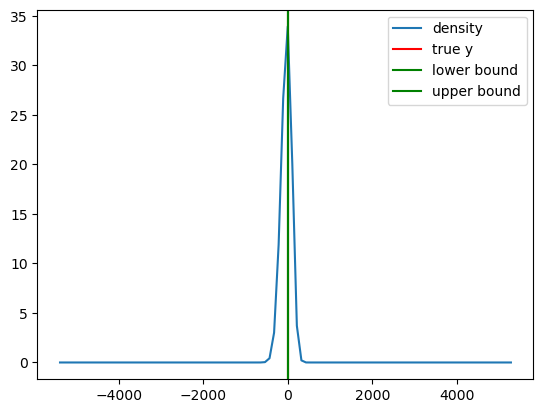

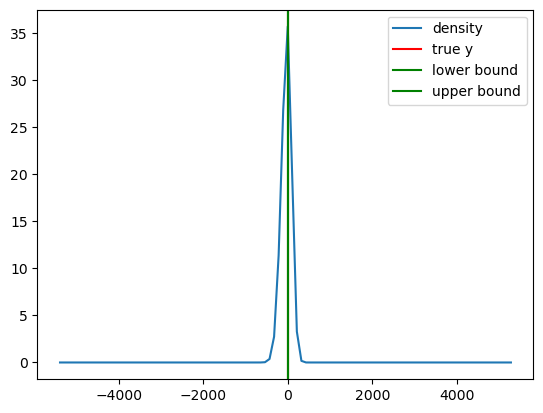

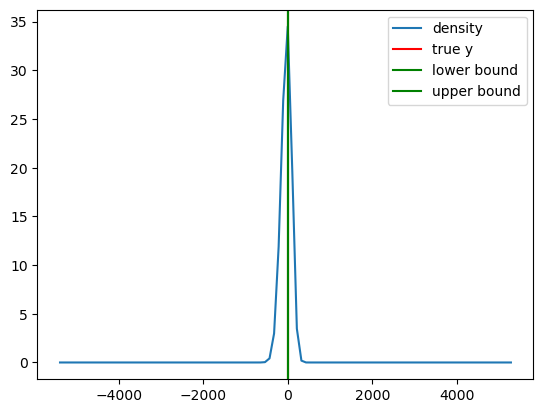

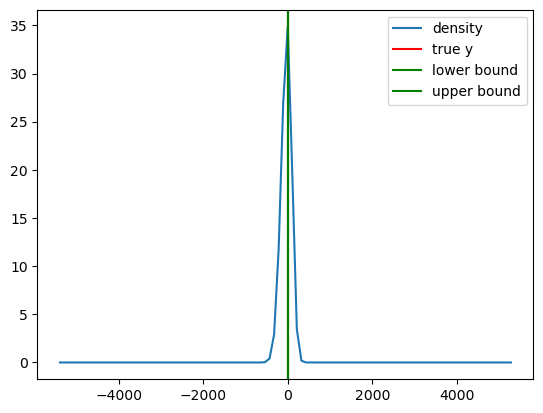

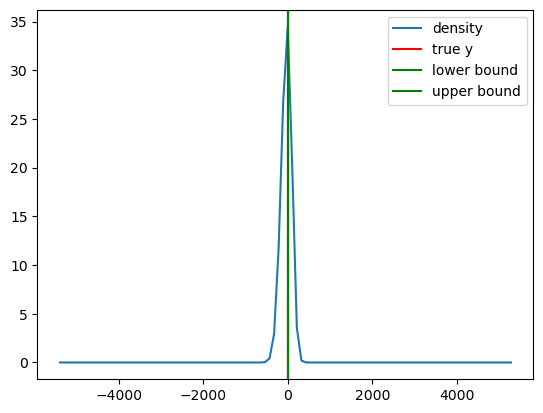

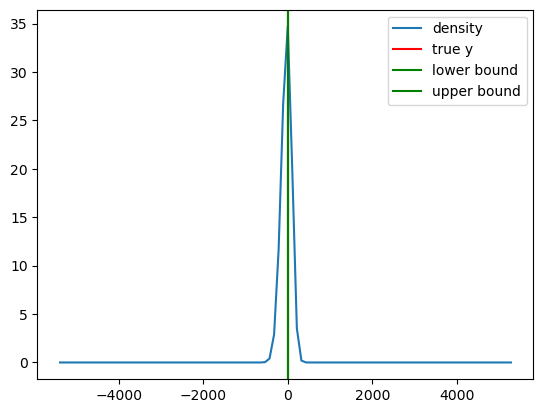

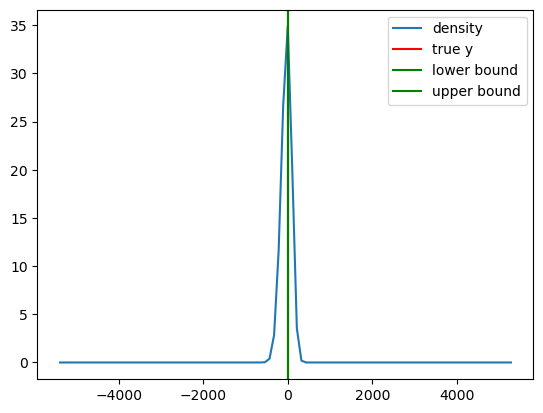

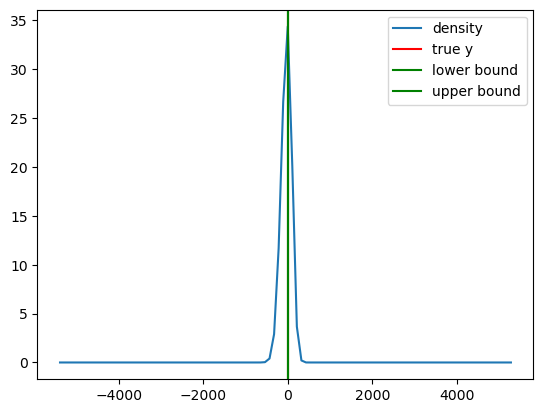

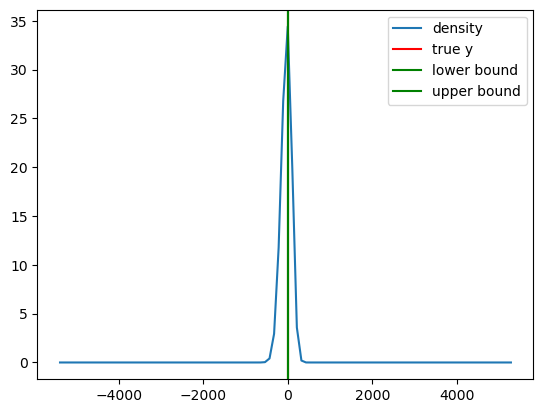

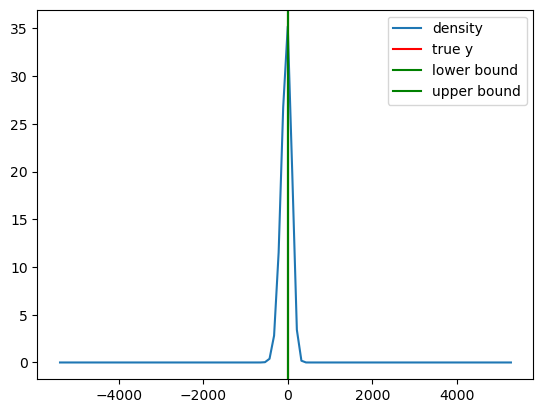

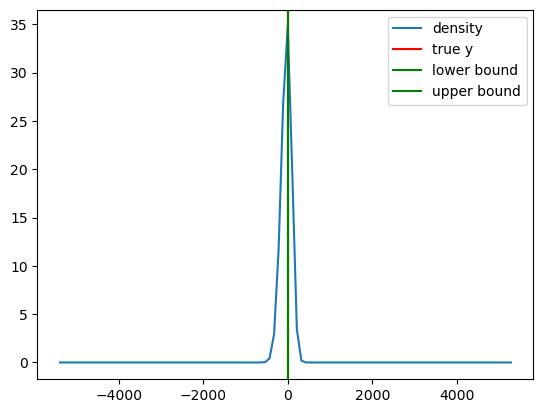

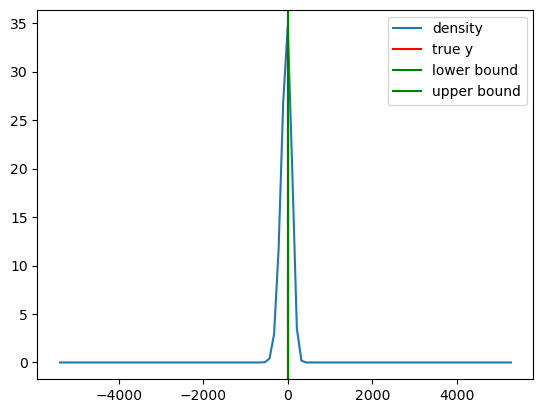

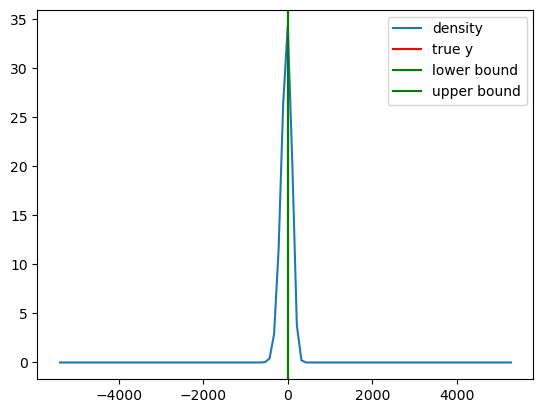

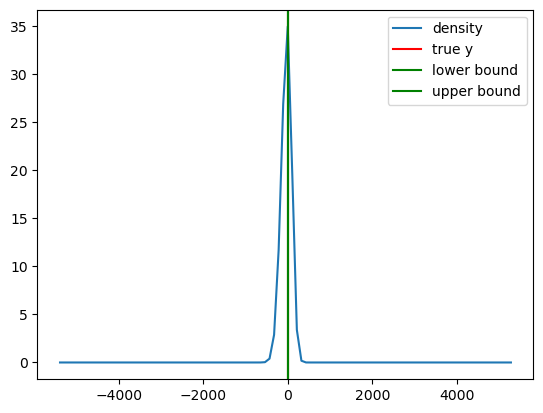

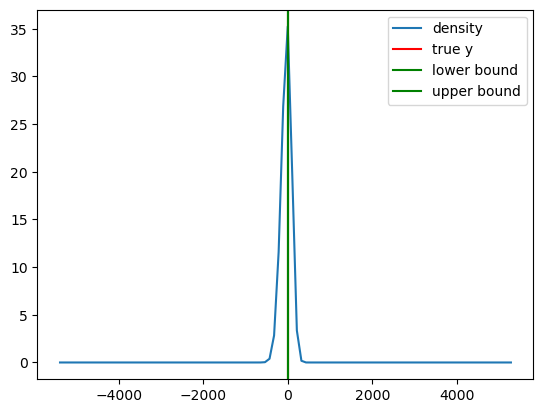

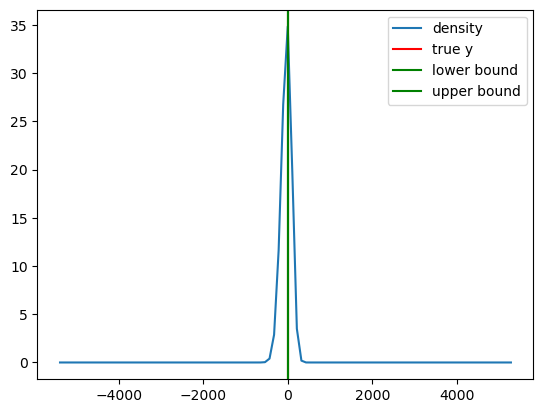

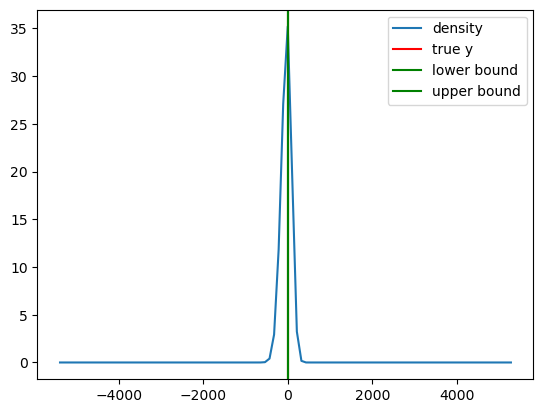

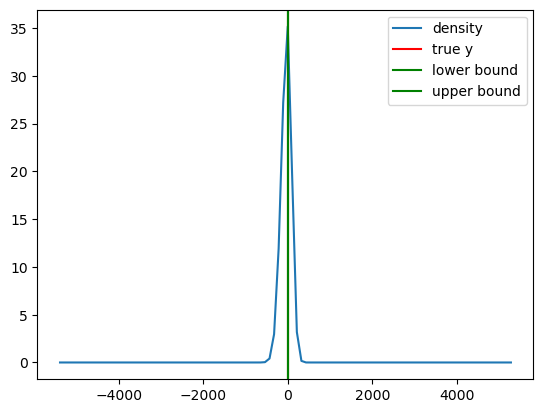

In [6]:
samples_for_plot = val_index[:30]
x_plot, y_plot = x_total[samples_for_plot], y_total[samples_for_plot]

max_min_difference = y_train.max() - y_train.min()
lower_bound = y_train.min() - max_min_difference * 1000.5
upper_bound = y_train.max() + max_min_difference * 1000.5

step_size = (upper_bound - lower_bound) / n_y_steps
steps = torch.tensor(np.arange(lower_bound, upper_bound, step_size)).view(-1, 1).float()

with torch.no_grad():
    for x, y in zip(x_plot, y_plot):
        x = torch.tensor(x).float()
        x = x.repeat(steps.shape[0], 1)
        
        net_input = torch.cat([x, steps], dim=1)
        x_hat, mean, logvar = model(net_input)

        normalizing_constant = (2 * torch.pi) ** (-mean.shape[1] / 2)
        exponent = -0.5 * torch.sum(mean * mean, dim=1)
        densities = normalizing_constant * torch.exp(exponent)

        prior_x = densities.mean()
        densities = densities / prior_x

        plt.plot(steps, densities, label='density')
        plt.axvline(y, label='true y', color = 'red')
        plt.axvline(y_train.min(), label='lower bound', color='green')
        plt.axvline(y_train.max(), label='upper bound', color="green")
        plt.legend()
        plt.show()

In [7]:
y_train.max() - y_train.min()

5.380411336302428

In [8]:
y_train.max(), y_train.min()

(2.823465851497239, -2.5569454848051887)

In [9]:
n_y_steps

100